OpenCV notebook - ©Arkaprabha Majumdar

# #1. Template matching / Pattern matches

In [2]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [90]:
image=cv2.imread("/home/arkaprabham/Desktop/Deep_Learning_Udemy/img/comic book pages/the-castafiore-emerald.jpg")
image_scaled=cv2.resize(image,None,fx=0.18,fy=0.18)
image_gray=cv2.cvtColor(image_scaled,cv2.COLOR_BGR2GRAY)
#adjust these values for your screen

cv2.imshow("tintin comic",image_scaled)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [93]:
image_df=pd.DataFrame(image_gray)

In [95]:
template=np.array(image_df.iloc[330:370,280:330])
cv2.imshow("template",template)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [96]:
result_mat=cv2.matchTemplate(image_gray,template,cv2.TM_CCOEFF)

min_x,max_x,min_y,max_y=cv2.minMaxLoc(result_mat)

In [98]:
#create a visible red bounding rectangle
cv2.rectangle(image_scaled,max_y,(max_y[0]+50,max_y[1]+50),(0,0,255),3)

cv2.imshow("Found",image_scaled)
cv2.waitKey(0)
cv2.destroyAllWindows()

Fairly simple  !!!

It's so simple, it's barely effective.

In fact, any transformation (affine and non affine,along with hue, saturation, contrast,etc) makes this method completely ineffective

So instead of this, we look for image features (i.e, interesting key areas of interest)

aka Key point features or interest points.

These all essentially boil down to the fact that no matter the transformation, many of these "feature points" will be common to the original and transformed image.
These are used in:

        o Image Alignment - stiching photos together to create a panaroma
        o 3D Reconstruction
        o Object Recognition
        o Motion Tracking
        o Robot navigation

#### "interesting points"
are the points which can uniquely define an image, and generally contains information like:

    o Changes in intensity
    o Corners / edges
    o Changes in contrast, etc
    
"Noise" must be removed, because they pose like information points.

### Good interesting features

    > Can be repeated over multiple pictures of the same scene
    > Each feature is unique and distinctive to nearby features
    > Number of features << Size of image. (efficiency)
    > Features must occupy small areas, and be robust to clutter and occlusion

# #2. Corner detection 

#### Two methods:

    > Harris corners (1988) https://www.bmva.com/bmvc/1988/acv-88-023.pdf"
    
    > Good Features to Track , an improvement on the above algorithm

### Harris Corners Algorithm

In [5]:
img=cv2.pyrDown(cv2.imread("/home/arkaprabham/Desktop/Deep_Learning_Udemy/img/shapes/shapess.jpg"))
cv2.imshow("Original image",img)
gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

gray=np.float32(gray)

harris_corners = cv2.cornerHarris(gray,3,3,0.05)
'''
arguments are:
    imput image
    blockSize (size of nbd)
    kSize (aperture param for Sobel derivative)
    k (harris detector free param) = 0.05
'''

kernel = np.ones((7,7),np.uint8)
harris_corners = cv2.dilate(harris_corners,kernel,iterations=2)

#Then we create a threshold cutoff at 25th quartile
img[harris_corners>0.025*harris_corners.max()] = [0,0,255]

cv2.imshow("Harris Corners", img)

cv2.waitKey(0)
cv2.destroyAllWindows()

### GFTT

In [15]:
img=cv2.pyrDown(cv2.imread("/home/arkaprabham/Desktop/Deep_Learning_Udemy/img/shapes/shapess.jpg"))
cv2.imshow("Original image",img)
gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

gray=np.float32(gray)
corners = cv2.goodFeaturesToTrack(gray,35,0.01,15)
# image, max corners to return, qualityLevel (max=1500,min=0.01) , minDistance

for corner in corners:
    x,y = corner[0]
    x = int(x)
    y = int(y)
    cv2.rectangle(img,(x-10,y-10),(x+10,y+10),(0,255,0),2)
    
cv2.imshow("Corners found",img)
cv2.waitKey(0)
cv2.destroyAllWindows()

As you can see, it captures the strong corners perfectly.

Also by tuning the various parameters, we'll get better corner detection :)

# #3. Histogram of Oriented Gradients

HOGs are widely used with SVM classifiers for object detection.

    1. Create a sliding window over the image
    2. Represent each sliding window by a matrix of intensities
    3. Calculate:
            change in horizontal intensities, H
            change in vertical intetnsities, V
            Normalization Factor = sqrt( H^2 + V^2) /(H+V)
       The NF remains constant for an image, regardless of intensity and contrast changes.
      

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

image=cv2.imread("/home/arkaprabham/Desktop/Deep_Learning_Udemy/img/Animals/big cat.jpg")

gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
cv2.imshow("Original Image",gray)
cv2.waitKey(0)

cell_size = (8,8) #kernel

block_size = (2,2)

nbins = 9 #same as original paper... 9 bins of 20 degrees each for a total of 180 degrees
cv2.destroyAllWindows()

In [10]:
#Calculate the Gradient Images
gx = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=1)
gy = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=1)

#Then calculate two matrices - magnitude and angle (/direction)

mag, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)
cv2.imshow("gx",gx)
cv2.imshow("gy",gy)
cv2.imshow("mag",mag)
cv2.imshow("angle",angle)
cv2.waitKey(0)
cv2.destroyAllWindows()

#### Calculate Histogram of Gradients in 8×8 cells
'''
the image is divided into 8×8 cells and a histogram of gradients is calculated for each 8×8 cells.
But why 8×8 patch ? Why not 32×32 ? 
It is a design choice informed by the scale of features we are looking for.
HOG was used for pedestrian detection initially. 8×8 cells in a photo of a pedestrian scaled to 64×128 are big enough to capture interesting features
The histogram is essentially a vector ( or an array ) of 9 bins ( numbers )
        corresponding to angles 0, 20, 40, 60 … 160'''

one 8×8 patch in the image is made up of two matrices associated with it.
    the gradient magnitude
    the gradient direction

In [13]:
print(mag.shape)
print(angle.shape)

(675, 1200)
(675, 1200)


In [97]:
#let's create the bins
angle_bins = np.zeros((9,))
bin_ls = [0,20,40,60,80,100,120,140,160]

In [98]:
#Let's flatten the arrays for angle and magnitude
flat_mag=np.ndarray.flatten(mag)
flat_angle=np.ndarray.flatten(angle/2)

In [99]:
for i in range(len(flat_angle)):
    lower_bin = int(flat_angle[i]/20)
    ratio = (flat_angle[i] - bin_ls[lower_bin]) /20
    if lower_bin<8:
        if ratio>0:
            angle_bins[lower_bin] += (1-ratio)*flat_mag[i]
            angle_bins[lower_bin+1] += (ratio)*flat_mag[i]
        else:
            angle_bins[lower_bin] += flat_mag[i]
    else:
        angle_bins[lower_bin] += (1-ratio)*flat_mag[i]
        angle_bins[0] += (1-ratio)*flat_mag[i]

In [100]:
sum(flat_mag)

10762959.008278131

In [101]:
sum(angle_bins)

10879903.665443642

<BarContainer object of 9 artists>

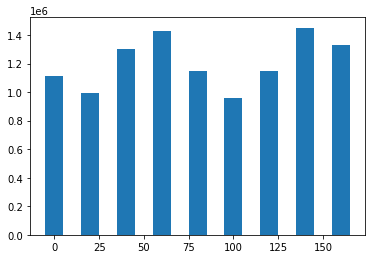

In [118]:
plt.bar(bin_ls,angle_bins,width=10)

In [119]:
!pip install seaborn
import seaborn as sns

     |████████████████████████████████| 215 kB 689 kB/s eta 0:00:01
     |████████████████████████████████| 25.8 MB 55 kB/s  eta 0:00:01     |████████████▉                   | 10.3 MB 1.5 MB/s eta 0:00:11


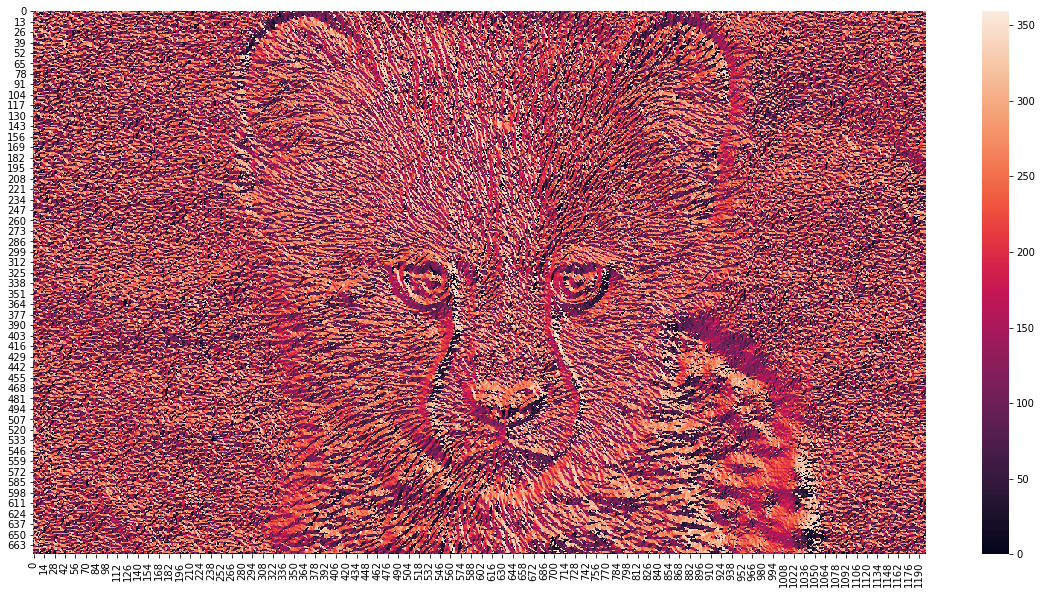

In [129]:
fig, ax = plt.subplots(figsize=(20,10))  
sns.heatmap(angle,ax=ax)